<a href="https://colab.research.google.com/github/nk555/AI-Projects/blob/master/GAN/MNIST_Style_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST learns your handwriting

This is a small project on using a GAN to generate numbers that look as someone else's handwriting when not trained on all numbers written by this person. For example say we had someone write the number 273 and we now want to write 481 in their own handwriting.

The main inspiration for this project is a paper I read recently called STAR GAN v2. In this paper they try to recognize diferent styles and features in images and transfer those into a different image. For example they are able to use image of different animals like dogs or tigers and making them look like a cat. Furthermore at the time of writing this it is currently a state-of-the-art method for this style translation tasks.

Some of the results can be seen at the end of this notebook. Unfortunately it seems not that many features were captured and mostly it was only the thickness of the numbers that was preserved. A reason this happens might be that the size of the images is small being 28x28. However, some ways to allow for more variation might be by exteding the number of layers being used, by having higher dimensional spaces for the latent and style spaces, or by giving a higher weight to the style diversification loss (look at section loss functions to see more about this).

The main purpose of this notebook is to make a small showcase of the architecture used in a simple design so that the ideas are simple to follow. This notebook will also contain some explanations and comments on the architecture of the neural network so that it might be easier to follow.

Note: another small thing I did in this project is to 'translate' STAR GAN code from pytorch to tensorflow. Redoing all of the work was useful to understand everything done on their code and having an option in tensorflow might be useful for some people.

For a small tutorial on how to write a simple GAN architecture: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

Link to STAR GAN v2: https://app.wandb.ai/stacey/stargan/reports/Cute-Animals-and-Post-Modern-Style-Transfer%3A-StarGAN-v2-for-Multi-Domain-Image-Synthesis---VmlldzoxNzcwODQ

Further Reading on style domain techniques for image generation:

Link to STAR GAN paper: https://arxiv.org/pdf/1912.01865.pdf

Link to Multimodal Unsupervised Image-to-Image Translation: https://arxiv.org/pdf/1804.04732.pdf

Link to Improving Style-Content Disentanglement Paper: https://arxiv.org/pdf/2007.04964.pdf

# Intitializing

In [1]:
import tensorflow as tf
from tensorflow_addons.layers import InstanceNormalization
import numpy as np
import tensorflow.keras.layers as layers
import time
from tensorflow.keras.datasets.mnist import load_data
import sys
import os
import datetime

# Layers

There are a few layers that were custom made. More importantly it is udeful to make this custom layers for the layers that try to incorporate style. This is as the inputs themselves are custom as you are inputing an image and a vector representing the style.

ResBlk is short for Residual Block, where it is predicting the residual (the difference between the original and the prediction).

In [2]:
class ResBlk(tf.keras.Model):
  def __init__(self, dim_in, dim_out, actv=layers.LeakyReLU(),
                 normalize=False, downsample=False):
    super(ResBlk, self).__init__()
    self.actv = actv
    self.normalize = normalize
    self.downsample = downsample
    self.learned_sc = dim_in != dim_out
    self._build_weights(dim_in, dim_out)

  def _build_weights(self, dim_in, dim_out):
    self.conv1 = layers.Conv2D(dim_in, 3, padding='same')
    self.conv2 = layers.Conv2D(dim_out, 3, padding='same')
    if self.normalize:
      self.norm1 = InstanceNormalization()
      self.norm2 = InstanceNormalization()
    if self.learned_sc:
      self.conv1x1 = layers.Conv2D(dim_out, 1)

  def _shortcut(self, x):
    if self.learned_sc:
        x = self.conv1x1(x)
    if self.downsample:
        x = layers.AveragePooling2D(pool_size=(2,2), padding='same')(x)
    return x
  
  def _residual(self, x):
    if len(tf.shape(x))>4:
      x=tf.reshape(x,tf.shape(x)[1:])
    if self.normalize:
      x = self.norm1(x)
    x = self.actv(x)
    x = self.conv1(x)
    if self.downsample:
      x = layers.AveragePooling2D(pool_size=(2,2), padding='same')(x)
    if self.normalize:
      x = self.norm2(x)
    x = self.actv(x)
    x = self.conv2(x)
    return x

  def call(self, x):
    x = self._shortcut(x) + self._residual(x)
    return x / 2**(1/2) # unit variance

AdaIN stands for Adaptive Instance Normalization. It is a type of normalization that allows to 'mix' two inputs. In this case we use the style vector to mix with our input x which is the image or part of the process of constructing this image.

In [3]:
class AdaIn(tf.keras.Model):
  def __init__(self, style_dim, num_features):
    super(AdaIn,self).__init__()
    self.norm = InstanceNormalization()
    self.lin = layers.Dense(num_features*2)

  def call(self, x, s):
    h=self.lin(s)
    h=tf.reshape(h, [tf.shape(h)[0], 1, 1, tf.shape(h)[1]])
    gamma,beta=tf.split(h, 2, axis=3)
    return (1+gamma)*self.norm(x)+beta

In [4]:
class AdainResBlk(tf.keras.Model):
  def __init__(self, dim_in, dim_out, style_dim=16,
                 actv=layers.LeakyReLU(), upsample=False):
    super(AdainResBlk, self).__init__()
    self.actv = actv
    self.upsample = upsample
    self.learned_sc = dim_in != dim_out
    self._build_weights(dim_in, dim_out, style_dim)

  def _build_weights(self, dim_in, dim_out, style_dim=16):
    self.conv1 = layers.Conv2D(dim_out, 3, padding='same')
    self.conv2 = layers.Conv2D(dim_out, 3, padding='same')
    self.norm1 = AdaIn(style_dim, dim_in)
    self.norm2 = AdaIn(style_dim, dim_out)
    if self.learned_sc:
      self.conv1x1 = layers.Conv2D(dim_out, 1)

  def _shortcut(self, x):
    if self.upsample:
        x = layers.UpSampling2D(size=(2,2), interpolation='nearest')(x)
    if self.learned_sc:
        x = self.conv1x1(x)
    return x

  def _residual(self, x, s):
    x = self.norm1(x, s)
    x = self.actv(x)
    if self.upsample:
      x = layers.UpSampling2D(size=(2,2), interpolation='nearest')(x)
    x = self.conv1(x)
    x = self.norm2(x, s)
    x = self.actv(x)
    x = self.conv2(x)
    return x

  def call(self, x, s):
    x = self._shortcut(x) + self._residual(x,s)
    return x / 2**(1/2) # unit variance

# Generator Class

In the generator we have two steps one for encoding the image into lower level information and one to decode back to the image. In this particular architecture the decoding uses the style to build back the image as it is an important part of the process. The decoding does not do this as we have the style encoder as an architecture that deals with this issue of generating a style vector for a particular image.

In [5]:
class Generator(tf.keras.Model):
  def __init__(self, img_size=28, style_dim=16, dim_in=8, max_conv_dim=128, repeat_num=1):
    super(Generator, self).__init__()
    self.img_size=img_size
    self.from_bw=layers.Conv2D(dim_in, 3, padding='same', input_shape=(1,img_size,img_size,1))
    self.encode=[]
    self.decode=[]
    self.to_bw=tf.keras.Sequential([InstanceNormalization(), layers.LeakyReLU(), layers.Conv2D(1, 1, padding='same')])

    for _ in range(repeat_num):
      dim_out = min(dim_in*2, max_conv_dim)
      self.encode.append(ResBlk(dim_in, dim_out, normalize=True, downsample=True))
      self.decode.insert(0, AdainResBlk(dim_out, dim_in, style_dim, upsample=True))
      dim_in = dim_out

    # bottleneck blocks
    for _ in range(2):
      self.encode.append(ResBlk(dim_out, dim_out, normalize=True))
      self.decode.insert(0, AdainResBlk(dim_out, dim_out, style_dim))

  def call(self, x, s):
    x = self.from_bw(x)
    cache = {}
    for block in self.encode:
      x = block(x)
    for block in self.decode:
      x = block(x, s)
    return self.to_bw(x)

# Mapping Network

The Mapping Network and the Style encoder are the parts of this architecture that make a difference in allowing style to be analyzed and put into our images. The mapping network will take as an input a latent code (represents images as a vector in a high dimensional space) and the domain in this case the domain is the number we are representing. And the style encoder will take as inputs an image and a domain.

In [6]:
class MappingNetwork(tf.keras.Model):
  def __init__(self, latent_dim=8, style_dim=16, num_domains=10):
    super(MappingNetwork,self).__init__()
    map_layers = [layers.Dense(128)]
    map_layers += [layers.ReLU()]
    for _ in range(2):
      map_layers += [layers.Dense(128)]
      map_layers += [layers.ReLU()]
    self.shared = tf.keras.Sequential(layers=map_layers)

    self.unshared = []
    for _ in range(num_domains):
      self.unshared += [tf.keras.Sequential(layers=[layers.Dense(128),
                                            layers.ReLU(),
                                            layers.Dense(128),
                                            layers.ReLU(),
                                            layers.Dense(128),
                                            layers.ReLU(),
                                            layers.Dense(style_dim)])]

  def call(self, z, y):
      h = self.shared(z)
      out = []
      for layer in self.unshared:
          out += [layer(h)]
      out = tf.stack(out, axis=1)  # (batch, num_domains, style_dim)
      s = tf.gather(out, y, axis=1)
      s = tf.gather_nd(s, [[i,i] for i in range(len(s))]) # (batch, style_dim)
      return s

# Style Encoder

An important thing to notice from the style encoder is that it takes as an input an image and outputs a style vector. Looking at the dimensions of these we notice we need to flatten out the image through the layers. This can usually be done in two ways. By flattening a 2 dimensional input to a 1 dimensional output a flatten layer, or as it was done hear by using enough pooling layers so that we downsample the size of our 2 dimensional input until it is one dimensional.

In [7]:
class StyleEncoder(tf.keras.Model):
  def __init__(self, img_size=28, style_dim=16, dim_in=8, num_domains=10, max_conv_dim=128, repeat_num=5):
    super(StyleEncoder,self).__init__()
    blocks = [layers.Conv2D(dim_in, 3, padding='same')]

    for _ in range(repeat_num):           #repetition 1 sends to (b,14,14,d) 2 to (b,7,7,d) 3 to (b,4,4,d) 4 to (b,2,2,d) 5 to (b,1,1,d)
      dim_out = min(dim_in*2, max_conv_dim)
      blocks += [ResBlk(dim_in, dim_out, downsample=True)]
      dim_in = dim_out

    blocks += [layers.LeakyReLU()]
    blocks += [layers.Conv2D(dim_out, 4, padding='same')]
    blocks += [layers.LeakyReLU()]
    self.shared = tf.keras.Sequential(layers=blocks)

    self.unshared = []
    for _ in range(num_domains):
      self.unshared += [layers.Dense(style_dim)]

  def call(self, x, y):
    h = self.shared(x)
    h = tf.reshape(h,[tf.shape(h)[0], tf.shape(h)[3]])
    out = []
    for layer in self.unshared:
      out += [layer(h)]
    out = tf.stack(out, axis=1)  # (batch, num_domains, style_dim)
    s = tf.gather(out, y, axis=1)  # (batch, style_dim)
    s = tf.gather_nd(s, [[i,i] for i in range(len(s))])
    return s

# Discriminator Class

Similarly to the Style encoder the input of the discriminator is an image and we need to downsample it until it is one dimensional.

In [8]:
class Discriminator(tf.keras.Model):
  def __init__(self, img_size=28, dim_in=8, num_domains=10, max_conv_dim=128, repeat_num=5):
    super(Discriminator, self).__init__()
    blocks = [layers.Conv2D(dim_in, 3, padding='same')]

    for _ in range(repeat_num):       #repetition 1 sends to (b,14,14,d) 2 to (b,7,7,d) 3 to (b,4,4,d) 4 to (b,2,2,d) 5 to (b,1,1,d)
      dim_out = min(dim_in*2, max_conv_dim)
      blocks += [ResBlk(dim_in, dim_out, downsample=True)]
      dim_in = dim_out

    blocks += [layers.LeakyReLU()]
    blocks += [layers.Conv2D(dim_out, 4, padding='same')]
    blocks += [layers.LeakyReLU()]
    blocks += [layers.Conv2D(num_domains, 1, padding='same')]
    self.main = tf.keras.Sequential(layers=blocks)


  def call(self, x, y):
    out = self.main(x)
    out = tf.reshape(out, (tf.shape(out)[0], tf.shape(out)[3]))  # (batch, num_domains)
    out = tf.gather(out, y, axis=1)  # (batch)
    #out = tf.reshape(out, [tf.shape(x)[0]])
    return out

# Loss Functions

The loss functions used are an important part of this model as it describes our goal when training and how to perform gradient descent. The discriminator loss function is the regular adversarial loss L_adv used in a GAN architecture. But furthermore we have three loss functions added.

For this loss functions if you want to see the mathematical formula I recommend looking at STAR GAN 2's paper. However I will explain what the loss tries to measure and a quick description of how it does so.

L_sty is a style reconstruction loss. This tries to capture how well the style was captured on our output. It is computed as an expected value of the distance between the target style vector and the style vector that our style encoder predicts for the generated image.

L_ds is a style diversification loss. It tries to capture that the images produced are different to promote a variety of images produced. It is computed as the expected value of the distance between the images (l_1 norm) generated when using two different styles and the same sources. 

L_cyc is a characteristic preserving loss. The cyc comes from cyclic as we measusre the distance between the original image and the image generated by using an image generated by this image and the style our style encoder provides as an input. (Notice we use the image generated by the image generated, so that we use the generator two times.)

In the end the total loss function is expressed as

L_adv + lambda_sty * L_sty + lambda_ds * L_ds + lambda_cyc * L_cyc

In [9]:
def moving_average(model, model_test, beta=0.999):
    for i in range(len(model.weights)):
      model_test.weights[i] = (1-beta)*model.weights[i] + beta*model_test.weights[i]

In [10]:
def adv_loss(logits, target):
    assert target in [1, 0]
    targets = tf.fill(tf.shape(logits), target)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(targets, logits)
    return loss

In [11]:
def r1_reg(d_out, x_in, g):
    # zero-centered gradient penalty for real images
    batch_size = tf.shape(x_in)[0]
    grad_dout=g.gradient(d_out, x_in)
    #grad_dout = tf.gradients(ys=d_out, xs=x_in)
    grad_dout2 = tf.square(grad_dout)
    grad_dout2 = tf.reshape(grad_dout2,[batch_size, tf.shape(grad_dout2)[1]*tf.shape(grad_dout2)[2]])
    reg = 0.5 * tf.math.reduce_mean(tf.math.reduce_sum(grad_dout2, axis=1))
    return reg

In [12]:
def compute_d_loss(nets, args, x_real, y_org, y_trg, z_trg=None, x_ref=None):
  assert (z_trg is None) != (x_ref is None)
  # with real images
  with tf.GradientTape() as g:
    g.watch(x_real)
    out = nets['discriminator'](x_real, y_org)
    loss_real = adv_loss(out, 1)
    loss_reg = r1_reg(out, x_real, g)

    # with fake images
  if z_trg is not None:
    s_trg = nets['mapping_network'](z_trg, y_trg)
  else:  # x_ref is not None
    s_trg = nets['style_encoder'](x_ref, y_trg)

  x_fake = nets['generator'](x_real, s_trg)
  out = nets['discriminator'](x_fake, y_trg)
  loss_fake = adv_loss(out, 0)

  loss = loss_real + loss_fake + args['lambda_reg'] * loss_reg
  return loss, {'real': loss_real, 'fake':loss_fake, 'reg':loss_reg}

In [13]:
def compute_g_loss(nets, args, x_real, y_org, y_trg, z_trgs=None, x_refs=None):
  assert (z_trgs is None) != (x_refs is None)
  if z_trgs is not None:
    z_trg, z_trg2 = z_trgs
  if x_refs is not None:
    x_ref, x_ref2 = x_refs

  # adversarial loss
  if z_trgs is not None:
    s_trg = nets['mapping_network'](z_trg, y_trg)
  else:
    s_trg = nets['style_encoder'](x_ref, y_trg)

  x_fake = nets['generator'](x_real, s_trg)
  out = nets['discriminator'](x_fake, y_trg)
  loss_adv = adv_loss(out, 1)

  # style reconstruction loss
  s_pred = nets['style_encoder'](x_fake, y_trg)
  loss_sty = tf.math.reduce_mean(tf.abs(s_pred - s_trg))

  # diversity sensitive loss
  if z_trgs is not None:
    s_trg2 = nets['mapping_network'](z_trg2, y_trg)
  else:
    s_trg2 = nets['style_encoder'](x_ref2, y_trg)
  x_fake2 = nets['generator'](x_real, s_trg2)
  loss_ds = tf.math.reduce_mean(tf.abs(x_fake - x_fake2))

  # cycle-consistency loss
  s_org = nets['style_encoder'](x_real, y_org)
  x_rec = nets['generator'](x_fake, s_org)
  loss_cyc = tf.math.reduce_mean(tf.abs(x_rec - x_real))

  loss = loss_adv + args['lambda_sty'] * loss_sty \
        - args['lambda_ds'] * loss_ds + args['lambda_cyc'] * loss_cyc
  return loss, {'adv':loss_adv, 'sty':loss_sty, 'ds':loss_ds, 'cyc':loss_cyc}

# The Model

Here we introduce the class Solver which is the most important class as this will represent our whole model. It will initiate all of our neural networks as well as train our network.

In [14]:
class Solver(tf.keras.Model):
  def __init__(self, args):
    super(Solver, self).__init__()
    self.args = args
    self.step=0

    self.nets, self.nets_ema = self.build_model(self.args)
    # below setattrs are to make networks be children of Solver, e.g., for self.to(self.device)
    for name in self.nets.keys():
      setattr(self, name, self.nets[name])
    for name in self.nets_ema.keys():
      setattr(self, name + '_ema', self.nets_ema[name])

    if args['mode'] == 'train':
      self.optims = {}
      for net in self.nets.keys():
        self.optims[net] = tf.keras.optimizers.Adam(learning_rate= args['f_lr'] if net == 'mapping_network' else args['lr'], 
                                                    beta_1=args['beta1'], beta_2=args['beta2'], 
                                                    epsilon=args['weight_decay'])

        self.ckptios = [tf.train.Checkpoint(model=net) for net in self.nets.values()]
        self.ckptios += [tf.train.Checkpoint(model=net_ema) for net_ema in self.nets_ema.values()]
        self.ckptios += [tf.train.Checkpoint(optimizer=optim) for optim in self.optims.values()]
    else:
      self.ckptios = [tf.train.Checkpoint(model=net_ema) for net_ema in self.nets_ema.values()]

    #for name in self.nets.keys():
      # Do not initialize the FAN parameters
     # print('Initializing %s...' % name)
      #self.nets[name].apply(initializer=tf.keras.initializers.HeNormal)

  def build_model(self, args):
    generator = Generator(args['img_size'], args['style_dim'])
    mapping_network = MappingNetwork(args['latent_dim'], args['style_dim'], args['num_domains'])
    style_encoder = StyleEncoder(args['img_size'], args['style_dim'], args['num_domains'])
    discriminator = Discriminator(args['img_size'], args['num_domains'])
    generator_ema = Generator(args['img_size'], args['style_dim'])
    mapping_network_ema = MappingNetwork(args['latent_dim'], args['style_dim'], args['num_domains'])
    style_encoder_ema = StyleEncoder(args['img_size'], args['style_dim'], args['num_domains'])

    nets = {'generator':generator, 'mapping_network':mapping_network,
            'style_encoder':style_encoder, 'discriminator':discriminator}
    nets_ema = {'generator':generator_ema, 'mapping_network':mapping_network_ema,
                'style_encoder':style_encoder_ema}

    nets['discriminator'](inputs['x_src'][0:2],inputs['y_src'][0:2])
    s_trg = nets['mapping_network'](inputs['z_trg'][0:2],inputs['y_src'][0:2])
    nets['generator'](inputs['x_src'][0:2],s_trg)
    nets['style_encoder'](inputs['x_src'][0:2], inputs['y_src'][0:2])
    s_trg = nets_ema['mapping_network'](inputs['z_trg'][0:2],inputs['y_src'][0:2])
    nets_ema['generator'](inputs['x_src'][0:2],s_trg)
    nets_ema['style_encoder'](inputs['x_src'][0:2], inputs['y_src'][0:2])

    return nets, nets_ema

  def save(self):
    for net in solv.nets.keys():
      solv.nets[net].save_weights('MNIST_GAN_3/saved_model/'+net+'step'+str(self.step)+'.h5')
    for net in solv.nets_ema.keys():
      solv.nets[net].save_weights('MNIST_GAN_3/saved_model/'+net+'step'+str(self.step)+'_ema.h5')
    
    
    #for ckptio in self.ckptios:
    #  ckptio.save(step)

  def load(self, step):
    self.step= step
    for net in solv.nets.keys():
      solv.nets[net].load_weights('MNIST_GAN_3/saved_model/'+net+'step'+str(step)+'.h5')
    for net in solv.nets_ema.keys():
      solv.nets[net].load_weights('MNIST_GAN_3/saved_model/'+net+'step'+str(step)+'_ema.h5')
    
    #for ckptio in self.ckptios:
    #  ckptio.load(step)

#  def _reset_grad(self):
#    for optim in self.optims.values():
#      optim.zero_grad()

  def train(self, inputs, validations, gen, batch_size=128):
    """
    inputs is a list of dictionaries that contains a source image, a reference image, domain and latent code information used to train the network
    validation is a list that contains validation images
    """

    args = self.args
    nets = self.nets
    nets_ema = self.nets_ema
    optims = self.optims

    # inputs_val=validations[0]

    # resume training if necessary
    if args['resume_iter'] > 0:
      self.load(args['resume_iter'])

    # remember the initial value of ds weight
    initial_lambda_ds = args['lambda_ds']

    print('Start training...')
    start_time = time.time()
    for i in range(args['resume_iter'], args['total_iters']):
      ind=(self.step*batch_size)%len(inputs['x_src'])
      self.step+=1
      # fetch images and labels

      x_real, y_org = gen.flow(inputs['x_src'][ind:ind+batch_size], inputs['y_src'][ind:ind+batch_size], batch_size=batch_size, shuffle=False)[0]
      x_real=tf.cast(x_real, tf.float32)
      x_ref, y_trg = gen.flow(inputs['x_ref'][ind:ind+batch_size], inputs['y_ref'][ind:ind+batch_size], batch_size=batch_size, shuffle=False)[0]
      x_ref=tf.cast(x_ref, tf.float32)
      x_ref2 = gen.flow(inputs['x_ref2'][ind:ind+batch_size], batch_size=batch_size, shuffle=False)[0]
      x_ref2=tf.cast(x_ref2, tf.float32)
      z_trg, z_trg2 = inputs['z_trg'][ind:ind+batch_size], inputs['z_trg2'][ind:ind+batch_size]

      #print(1.5)

      # train the discriminator
      with tf.GradientTape() as g:
        g.watch(nets['discriminator'].weights)

        d_loss, d_losses_latent = compute_d_loss(
                nets, args, x_real, y_org, y_trg, z_trg=z_trg)
        #self._reset_grad()
        #d_loss.backward()
        grad=g.gradient(d_loss, nets['discriminator'].weights)
        #optims['discriminator'].get_gradients(d_loss, nets['discriminator'].weights)
        optims['discriminator'].apply_gradients(zip(grad, nets['discriminator'].weights))

      #print(2)

      with tf.GradientTape() as g:
        g.watch(nets['discriminator'].weights)
        d_loss, d_losses_ref = compute_d_loss(
                nets, args, x_real, y_org, y_trg, x_ref=x_ref)
        #self._reset_grad()
        #d_loss.backward()
        grad=g.gradient(d_loss, nets['discriminator'].weights)
        optims['discriminator'].apply_gradients(zip(grad, nets['discriminator'].weights))

      #print(3)

      # train the generator
      with tf.GradientTape(persistent=True) as g:
        g.watch(nets['generator'].weights)
        g.watch(nets['mapping_network'].weights)
        g.watch(nets['style_encoder'].weights)
        g_loss, g_losses_latent = compute_g_loss(
                nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2])
        #self._reset_grad()
        #g_loss.backward()
      grad=g.gradient(g_loss, nets['generator'].weights)
      optims['generator'].apply_gradients(zip(grad, nets['generator'].weights))
      grad=g.gradient(g_loss, nets['mapping_network'].weights)
      optims['mapping_network'].apply_gradients(zip(grad, nets['mapping_network'].weights))
      grad=g.gradient(g_loss, nets['style_encoder'].weights)
      optims['style_encoder'].apply_gradients(zip(grad, nets['style_encoder'].weights))
      del g

      #print(4)
      with tf.GradientTape(persistent=True) as g:
        g.watch(nets['generator'].weights)
        g_loss, g_losses_ref = compute_g_loss(
                nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2])
        #self._reset_grad()
        #g_loss.backward()
      grad=g.gradient(g_loss, nets['generator'].weights)
      optims['generator'].apply_gradients(zip(grad, nets['generator'].weights))
      del g

      #print(5)

      # compute moving average of network parameters
      moving_average(nets['generator'], nets_ema['generator'], beta=0.999)
      moving_average(nets['mapping_network'], nets_ema['mapping_network'], beta=0.999)
      moving_average(nets['style_encoder'], nets_ema['style_encoder'], beta=0.999)

      #print(6)

      # decay weight for diversity sensitive loss
      if args['lambda_ds'] > 0:
        args['lambda_ds'] -= (initial_lambda_ds / args['ds_iter'])

      # print out log info
      if (i+1) % args['print_every'] == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args['total_iters'])
        all_losses = {}
        for loss, prefix in [(d_losses_latent,'D/latent_'), (d_losses_ref,'D/ref_'), 
                             (g_losses_latent,'G/latent_'), (g_losses_ref,'G/ref_')]:
          for key, value in loss.items():
            all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args['lambda_ds']
        for key, value in all_losses.items():
          if key!= 'G/lambda_ds':
            print(log+key, value.numpy())
          else:
            print(log+key, value)

      # generate images for debugging
      #if (i+1) % args['sample_every'] == 0:
      #  os.makedirs(args['sample_dir'], exist_ok=True)
      #  debug_image(nets_ema, args, inputs=inputs_val, step=i+1)

      # save model checkpoints
      if (i+1) % args['save_every'] == 0:
        for net in solv.nets.keys():
          solv.nets[net].save_weights('MNIST_GAN_3/saved_model/'+net+'step'+str(self.step)+'.h5')
        for net in solv.nets_ema.keys():
          solv.nets[net].save_weights('MNIST_GAN_3/saved_model/'+net+'step'+str(self.step)+'_ema.h5')
      
      
      #  self._save_checkpoint(step=i+1)

  def sample(self, src, ref):
    """
    src     source image that we want to modify
    ref     pair of reference image and domain

    generates an image that changes source image into the style of the reference image 
    """
    args = self.args
    nets_ema = self.nets_ema
    os.makedirs(args['result_dir'], exist_ok=True)
    self._load_checkpoint(args['resume_iter'])

    fname = ospj(args['result_dir'], 'reference.jpg')
    print('Working on {}...'.format(fname))
    translate_using_reference(nets_ema, args, src, ref[0], ref[1], fname)

# Data Loading and Preprocessing

In [15]:
(trainX, trainy), (valX, valy) = load_data()

trainX=tf.reshape(trainX, (60000,28,28,1))
valX=tf.reshape(valX, (10000,28,28,1))

In [16]:
x_src=tf.cast(trainX, tf.float32)
y_src=tf.cast(trainy, tf.int32)
x_ref=tf.random.shuffle(x_src, seed=0)
x_ref2=tf.random.shuffle(x_src, seed=1)
y_ref=tf.random.shuffle(y_src, seed=0)
z_trg=tf.random.normal((60000,8))
z_trg2=tf.random.normal((60000,8))

inputs={"x_src":x_src, "y_src":y_src, "x_ref":x_ref, "x_ref2":x_ref2, "y_ref":y_ref, "z_trg":z_trg, "z_trg2":z_trg2}

# Data Augmentation

We can do some things to augment our data set like transforming our images by 

In [17]:
img_gen=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15 , width_shift_range=2, height_shift_range=2, zoom_range=0.1)
img_gen.fit(x_src)

# Parameters

In [18]:
args={'img_size':28,
      'style_dim':16,
      'latent_dim':8,
      'num_domains':10,
      'lambda_reg':1, 
      'lambda_ds':1,
      'lambda_sty':1,
      'lambda_cyc':1,
      'hidden_dim':128,
      'resume_iter':0,
      'ds_iter':2000,  
      'total_iters':2000,
      'batch_size':128,
      'val_batch_size':32,  
      'lr':1e-4,
      'f_lr':1e-6,
      'beta1':0,
      'beta2':0.99,
      'weight_decay':1e-4,
      'num_outs_per_domain':4,
      'mode': 'train',  #train,sample,eval
      'seed':0,
      'train_img_dir':'GAN/data/train',
      'val_img_dir': 'GAN/data/val',
      'sample_dir':'GAN/res/samples',
      'checkpoint_dir':'GAN/res/checkpoints',
      'eval_dir':'GAN/res/eval',
      'result_dir':'GAN/res/results',
      'src_dir':'GAN/data/src', 
      'ref_dir':'GAN/data/ref',
      'print_every': 500,
      'sample_every':20000,
      'save_every':500,
      'eval_every':1000 }

# Load Model

In [19]:
solv=Solver(args)
solv.build_model(args)
solv.load(500)

# Training

In [20]:
with tf.device('/device:GPU:0'):
    solv.train(inputs, inputs, img_gen)

Start training...


KeyboardInterrupt: 

# Results

In this first cell we show an image where the rows represent a source image and the columns the style they are trying to mimic. We can see in this case that that the image still highly resembles the source image but has obtained some characteristics depending on the style of our reference. In most cases this style is mostly about the thickness of the lines, but it does vary slightly in other ways.

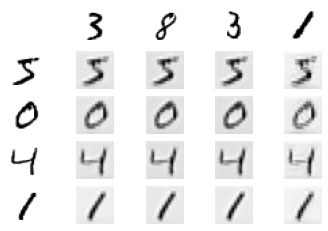

In [39]:
import matplotlib.pyplot as pyplot
for i in range(4):
	pyplot.subplot(5,5,2+i)
	pyplot.axis('off')
	pyplot.imshow(np.reshape(inputs['x_ref'][i],[28,28]), cmap='gray_r')
for i in range(4):
	pyplot.subplot(5, 5, 5*(i+1) + 1)
	pyplot.axis('off')
	pyplot.imshow(np.reshape(inputs['x_src'][i], [28,28]), cmap='gray_r')
	for j in range(4):
		pyplot.subplot(5, 5, 5*(i+1) + j +2)
		pyplot.axis('off')
		pyplot.imshow(np.reshape(solv.nets['generator'](inputs['x_src'][i:i+1],solv.nets['style_encoder'](inputs['x_ref'][j:j+1],inputs['y_ref'][j:j+1])).numpy(), [28,28]), cmap='gray_r')
pyplot.show()

#left is source and top is the target trying to mimic its font

Below we generate random styles and see the output it generates. We notice that it is quite likely the images are distorted in this case, compared to when using the style of an already existing image it seems it would usually have a good quality.

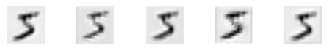

In [40]:
for i in range(5):
	pyplot.subplot(5,5,1+i)
	pyplot.axis('off')
	pyplot.imshow(np.reshape(solv.nets['generator'](inputs['x_src'][0:1],tf.random.normal((1,16))).numpy(), [28,28]), cmap='gray_r')

Here we can see the process of how the image transforms into the target. In these small images there is not too much that is changing but we can still appreciate the process.

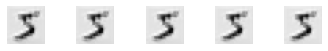

In [41]:
s1=solv.nets['style_encoder'](inputs['x_src'][0:1],inputs['y_src'][0:1])
s2=solv.nets['style_encoder'](inputs['x_ref'][0:1],inputs['y_ref'][0:1])
for i in range(5):
  pyplot.subplot(5,5,1+i)
  pyplot.axis('off')
  s=(1-i/5)*s1+i/5*s2
  pyplot.imshow(np.reshape(solv.nets['generator'](inputs['x_src'][0:1],s).numpy(), [28,28]), cmap='gray_r')